# Warehouse Optimization (Model Only)

## Initilization

In [194]:
import pandas as pd
import pandas_profiling
import numpy as np
data = pd.read_csv('ML_datafile.csv')
data.reset_index(drop=True, inplace=True)
data = data.drop(['Item No', 'Manufacturer No', 'Product Name', 'Date', 'STOCK TYPE', 'In Stock', 'List No',
                 'UPC Code', 'SaleRate'], axis=1)
data

,Manufacturer,Category,Category Path 1,Category Path 2,Category Path 3,Price(USD),Cost price,Inventory,Shipping,Profit,weight(lb),SaleRateNew,Blowout
0,Supermicro,Power Cable,Component,Cable,Power Cable,10.25,7.6875,1,2.5,0.0625,1.00,0.000000,1000.000000
1,ASUS,Bag & Sleeve,PC & Laptop,Accessory,Bag & Sleeve,9.23,4.2300,1,2.5,2.5000,0.50,0.000000,1000.000000
2,AMD,Others,Component,CPU / Processor,Desktop CPU,76.88,57.6600,1,2.5,16.7200,0.74,0.000000,1000.000000
3,QNAP,DDR3 1333,Component,DRAM Memory,Notebook DRAM,76.88,57.6600,1,0.0,19.2200,0.10,0.000000,1000.000000
4,Supermicro,Accessory,Hardware & Software,Server & Workstation,Accessory,92.76,69.5700,1,2.5,20.6900,0.50,0.000000,1000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4195,NVIDIA,Nvidia,Component,Video Card,PCI Express Video Card,3854.00,2890.5000,1,2.5,961.0000,5.00,0.370787,2.696970
4196,Supermicro,Accessory,Hardware & Software,Server & Workstation,Accessory,20.50,15.3750,1,2.5,2.6250,0.50,0.377778,2.647059
4197,In Win,2U,Component,Server,Server Chassis,72.00,54.0000,1,3.5,14.5000,24.12,0.377778,2.647059
4198,iStarUSA,3U,Component,Server,Server Chassis,143.50,107.6250,1,10.0,25.8750,29.00,0.377778,2.647059


In [195]:
# limit to categorical data using df.select_dtypes()
#nominal_data = data.drop(['Price(USD)', 'Cost price', 'Inventory', 'Shipping', 'Profit', 'weight(lb)', 'SaleRateNew'], axis=1)
#ordinal_data = data.drop(nominal_data.columns)
nominal_data = data.select_dtypes(include=[object])
ordinal_data = data.drop(list(nominal_data.columns), axis=1)
nominal_data = nominal_data.replace(np.nan, 'Default', regex=True)

## One-Hot Encoding

In [196]:
from sklearn import preprocessing
nominal_data_2 = nominal_data
# 1. INSTANTIATE
enc = preprocessing.OneHotEncoder()
# 2. FIT
enc.fit(nominal_data_2)
# 3. Transform
onehotlabels = enc.transform(nominal_data_2).toarray()
print(onehotlabels.shape)

(4200, 458)


In [197]:
encoded_data = pd.concat([ordinal_data, pd.DataFrame(onehotlabels)], axis=1)

In [198]:
encoded_data.columns


Index([ 'Price(USD)',  'Cost price',   'Inventory',    'Shipping',
            'Profit',  'weight(lb)', 'SaleRateNew',     'Blowout',
                   0,             1,
       ...
                 448,           449,           450,           451,
                 452,           453,           454,           455,
                 456,           457],
      dtype='object', length=466)

## Data Split

In [199]:
X = encoded_data.drop('SaleRateNew', axis=1)
Y = encoded_data['SaleRateNew']

## Tunning

In [200]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor

In [201]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size= 0.2)

In [210]:
#Regression	 	 
#‘explained_variance’	metrics.explained_variance_score	 
#‘max_error’	metrics.max_error	 
#‘neg_mean_absolute_error’	metrics.mean_absolute_error	 
#‘neg_mean_squared_error’	metrics.mean_squared_error	 
#‘neg_mean_squared_log_error’	metrics.mean_squared_log_error	 
#‘neg_median_absolute_error’	metrics.median_absolute_error	 
#‘r2’	metrics.r2_score

from matplotlib import pyplot as plt
%matplotlib inline

def test(models, X, Y, iterations = 20):
    results = {}
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size= 0.2)
    for i in models:
        print("\nRunning ", i)
        r2_train = []
        r2_test = []
        mae_train = []
        mae_test = []
        for j in range(iterations):
            print(j, end='')
            r2_test.append(metrics.r2_score(y_test,
                                            models[i].fit(X_train, 
                                                         y_train).predict(X_test)))
            r2_train.append(metrics.r2_score(y_train, 
                                             models[i].fit(X_train, 
                                                          y_train).predict(X_train)))
            mae_test.append(metrics.mean_absolute_error(y_test,
                                            models[i].fit(X_train, 
                                                         y_train).predict(X_test)))
            mae_train.append(metrics.mean_absolute_error(y_train, 
                                             models[i].fit(X_train, 
                                                          y_train).predict(X_train)))
        plt.figure()
        plt.plot(r2_test, label='r2_test')
        plt.xlabel('Iterations') 
        plt.ylabel('Score')
        plt.title("r2_test")
        plt.figure()
        plt.plot(r2_train, label='r2_train')
        plt.xlabel('Iterations') 
        plt.ylabel('Score') 
        plt.title("r2_train")
        results[i] = [np.mean(r2_train), np.mean(r2_test), np.mean(mae_train), np.mean(mae_test)]
    return pd.DataFrame(results), models

In [211]:
models = {'OLS': linear_model.LinearRegression(),
         #'Lasso': linear_model.Lasso(),
        # 'Ridge': linear_model.Ridge(),
         #'Ada': AdaBoostRegressor(),
         #'GBM': GradientBoostingRegressor(),
         #'BR': BaggingRegressor,
         'RFR' :RandomForestRegressor() }


Running  OLS
012345678910111213141516171819
Running  RFR
0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


12345678910111213141516171819Wall time: 1min 13s


,OLS,RFR
0,0.745570,0.997827
1,0.744569,0.987435
2,0.376023,0.012437
3,0.436677,0.038837


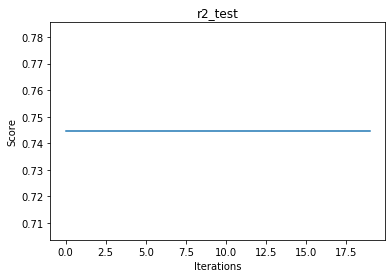

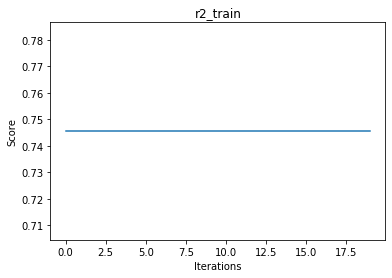

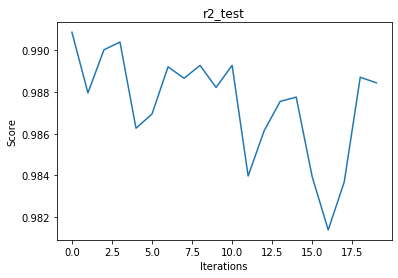

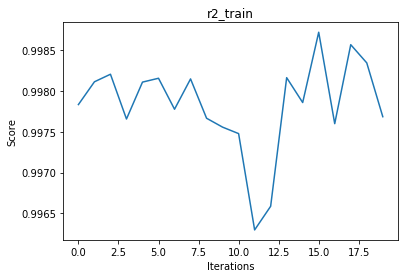

In [212]:
%time result, models = test(models, X, Y)
result

In [32]:
y_test.head(10)

1273    0.140351
2573    3.763158
51      0.066667
712     0.012987
1254    0.034483
3134    0.689655
1183    0.100000
2542    0.050000
896     0.750000
4188    0.344444
Name: SaleRateNew, dtype: float64

In [33]:
y_pred = models['OLS'].predict(X_test)
y_pred[:10]

array([ 0.40988011,  2.54073479, -0.31084114, -0.08165766,  0.32801483,
        0.7099669 ,  0.17583155,  0.12072664,  1.5068451 ,  0.54001803])

### Tunning

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)



Running  Ada
0123456789
Running  GBM
0123456789Wall time: 6min 59s


(        Ada       GBM
 0  0.925009  0.995754
 1  0.929448  0.988797
 2  0.236655  0.030004
 3  0.267675  0.045687,
 {'Ada': AdaBoostRegressor(base_estimator=None, learning_rate=1, loss='linear',
                    n_estimators=100, random_state=None),
  'GBM': GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                            learning_rate=0.3, loss='huber', max_depth=3,
                            max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,
                            min_samples_leaf=1, min_samples_split=2,
                            min_weight_fraction_leaf=0.0, n_estimators=100,
                            n_iter_no_change=None, presort='auto',
                            random_state=None, subsample=1.0, tol=0.0001,
                            validation_fraction=0.1, verbose=0, warm_start=False)})

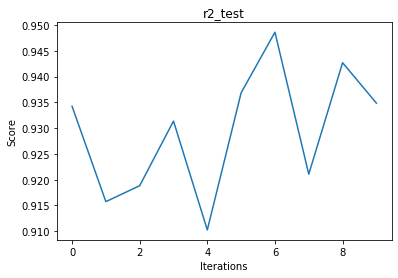

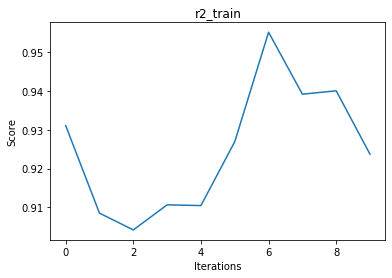

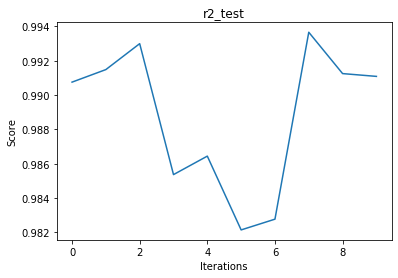

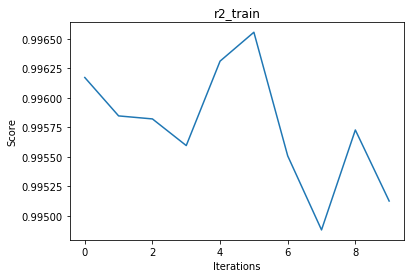

In [38]:
ada_param = {
 'n_estimators': [50, 100],
 'learning_rate' : [0.01,0.05,0.1,0.3,1],
 'loss' : ['linear', 'square', 'exponential']
 }

gbm_param = {
 'n_estimators': [50, 100],
 'learning_rate' : [0.01,0.05,0.1,0.3,1],
 'loss' : ['ls', 'lad', 'huber', 'quantile']
 }

models2 = {'Ada': GridSearchCV(AdaBoostRegressor(), 
                               param_grid=ada_param).fit(X, Y).best_estimator_,
          'GBM': GridSearchCV(GradientBoostingRegressor(), 
                               param_grid=gbm_param).fit(X, Y).best_estimator_}
%time test(models2, X, Y)

In [35]:
y_pred = models2['GBM'].predict(X_test)
print(y_pred[:10])
print(y_test.head(10))

[1.61317019e-01 3.72611279e+00 5.39236805e-02 2.45499874e-03
 3.74817706e-02 7.54139986e-01 1.11254949e-01 6.98592784e-02
 7.42433094e-01 3.46542686e-01]
1273    0.140351
2573    3.763158
51      0.066667
712     0.012987
1254    0.034483
3134    0.689655
1183    0.100000
2542    0.050000
896     0.750000
4188    0.344444
Name: SaleRateNew, dtype: float64


In [39]:
X_test.Inventory

1273      8
2573    145
51       14
712       1
1254      2
       ... 
3101     29
209      52
1233     52
3515     14
2869     52
Name: Inventory, Length: 840, dtype: int64

In [40]:
models2['Ada']

AdaBoostRegressor(base_estimator=None, learning_rate=1, loss='linear',
                  n_estimators=100, random_state=None)

In [41]:
models2['GBM']

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.3, loss='huber', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

#### Number of days prediction (i.e Blowout period)

In [42]:
#blowout
#np.set_printoptions(formatter={'float_kind':float_formatter})
X_test['y_pred'] = y_pred
X_test['blowout_pred'] = pd.DataFrame({"Days" : X_test.Inventory / X_test['y_pred']})
X_test.head(10)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Price(USD),Cost price,Inventory,Shipping,Profit,weight(lb),Blowout,0,1,2,...,450,451,452,453,454,455,456,457,y_pred,blowout_pred
1273,141.45,106.0875,8,2.5,32.8625,4.00,57.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.161317,49.591792
2573,525.31,393.9825,145,2.5,128.8275,1.65,38.531469,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.726113,38.914549
51,23.06,17.2950,14,2.5,3.2650,1.90,209.999999,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.053924,259.626195
712,584.25,438.1875,1,10.0,136.0625,36.00,77.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002455,407.332185
1254,2868.98,2151.7350,2,3.5,713.7450,11.20,57.999999,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037482,53.359272
3134,48.18,36.1350,20,0.0,12.0450,0.10,29.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.754140,26.520275
1183,224.48,168.3600,6,10.0,46.1200,39.20,60.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111255,53.930185
2542,676.50,507.3750,2,10.0,159.1250,45.00,40.000000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.069859,28.628982
896,52.28,39.2100,51,2.5,10.5700,0.24,68.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.742433,68.693059
4188,10.25,7.6875,1,2.5,0.0625,0.12,2.903226,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.346543,2.885647
